# 03: DELAY ANALYSIS

¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo?
¿Qué variables esperarías que más influyeran en predecir atrasos?

In [124]:
# Librerías Principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Funciones Personalizadas
from utils.synthetic_features import temporada_alta
from utils.synthetic_features import periodo_dia

from scipy.stats import f_oneway, ttest_ind
import statsmodels.formula.api as sts

from itertools import combinations

# Configuración General
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 8})

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../data/dataset_SCL.csv')

/var/folders/q4/hqn7rgnd2776w9b_lc4r0vlr0000gn/T/ipykernel_10399/3157898594.py:1: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/dataset_SCL.csv')


In [30]:
# Transformar variables de fecha de string a datetime para cálculo de nuevas variables
df['Fecha-I'] = pd.to_datetime(df['Fecha-I'])
df['Fecha-O'] = pd.to_datetime(df['Fecha-O'])

# Agregar Variable Fecha
df['fecha'] = df['Fecha-I'].dt.date

# Nuevas Variables: Temporada
df['temporada_alta'] = df['Fecha-I'].apply(temporada_alta)
df['temporada_alta_enriched'] = df['Fecha-I'].apply(temporada_alta, enriched=True)

# Nuevas Variables: Atraso en Minutos
df['dif_min'] = (df['Fecha-O'] - df['Fecha-I']).apply(lambda x: x.total_seconds() / 60)
df['atraso_15'] = df['dif_min'].apply(lambda x: 1 if x>15 else 0)

# Nuevas Variables: Periodo del Día (mañana, tarde, noche)
df['periodo_dia'] = df['Fecha-I'].apply(periodo_dia)

# Dia de la semana en formato numérico (1: Lunes, 7: Domingo)
df['SEMANA'] = df['Fecha-O'].dt.strftime('%Y%W')
df['DOW'] = df['Fecha-O'].dt.dayofweek + 1

In [10]:
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,OPERA,SIGLAORI,SIGLADES,temporada_alta,temporada_alta_enriched,dif_min,atraso_15,periodo_dia,SEMANA,DOW
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,1,1,3.0,0,noche,201700,7
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,1,1,9.0,0,noche,201701,1
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,1,1,9.0,0,noche,201701,2
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,1,1,3.0,0,noche,201701,3
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,1,1,-2.0,0,noche,201701,4


#### Tasa de Atraso

In [11]:
df.describe()

,DIA,MES,AÑO,temporada_alta,temporada_alta_enriched,dif_min,atraso_15,DOW
count,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000
mean,15.714790,6.622585,2017.000029,0.333724,0.492127,9.110855,0.184940,3.955209
std,8.782886,3.523321,0.005415,0.471546,0.822751,19.313387,0.388252,1.994333
min,1.000000,1.000000,2017.000000,0.000000,0.000000,-14.000000,0.000000,1.000000
25%,8.000000,3.000000,2017.000000,0.000000,0.000000,-1.000000,0.000000,2.000000
50%,16.000000,7.000000,2017.000000,0.000000,0.000000,4.000000,0.000000,4.000000
75%,23.000000,10.000000,2017.000000,1.000000,1.000000,12.000000,0.000000,6.000000
max,31.000000,12.000000,2018.000000,1.000000,3.000000,161.000000,1.000000,7.000000


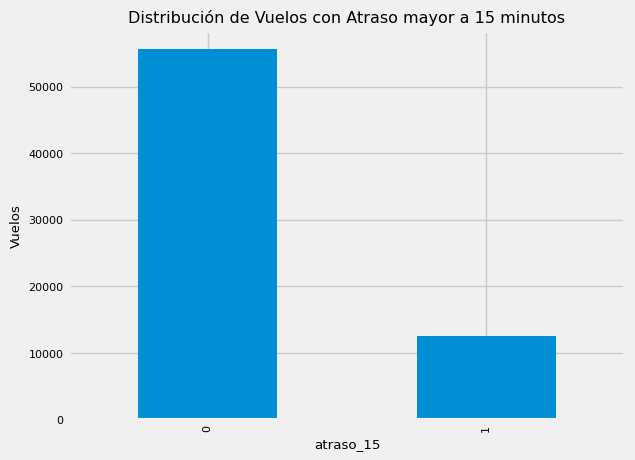

In [212]:
df.groupby('atraso_15')['Fecha-I'].count().plot.bar()
plt.title('Distribución de Vuelos con Atraso mayor a 15 minutos')
plt.ylabel('Vuelos')
plt.savefig('results/img/02_DELAY_ANALYSIS_GENERAL-DIST.png')
plt.show()

¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo? ¿Qué variables esperarías que más influyeran en predecir atrasos?



In [13]:
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,OPERA,SIGLAORI,SIGLADES,temporada_alta,temporada_alta_enriched,dif_min,atraso_15,periodo_dia,SEMANA,DOW
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,1,1,3.0,0,noche,201700,7
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,1,1,9.0,0,noche,201701,1
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,1,1,9.0,0,noche,201701,2
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,1,1,3.0,0,noche,201701,3
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,1,1,-2.0,0,noche,201701,4


In [27]:
storage = {}
for variable in ['SIGLADES', 'OPERA', 'MES', 'DOW', 'temporada_alta', 'temporada_alta_enriched', 'TIPOVUELO']:
    results_tmp = df.groupby(variable)[['atraso_15']].agg(['count','mean','std'])
    storage[variable] = results_tmp

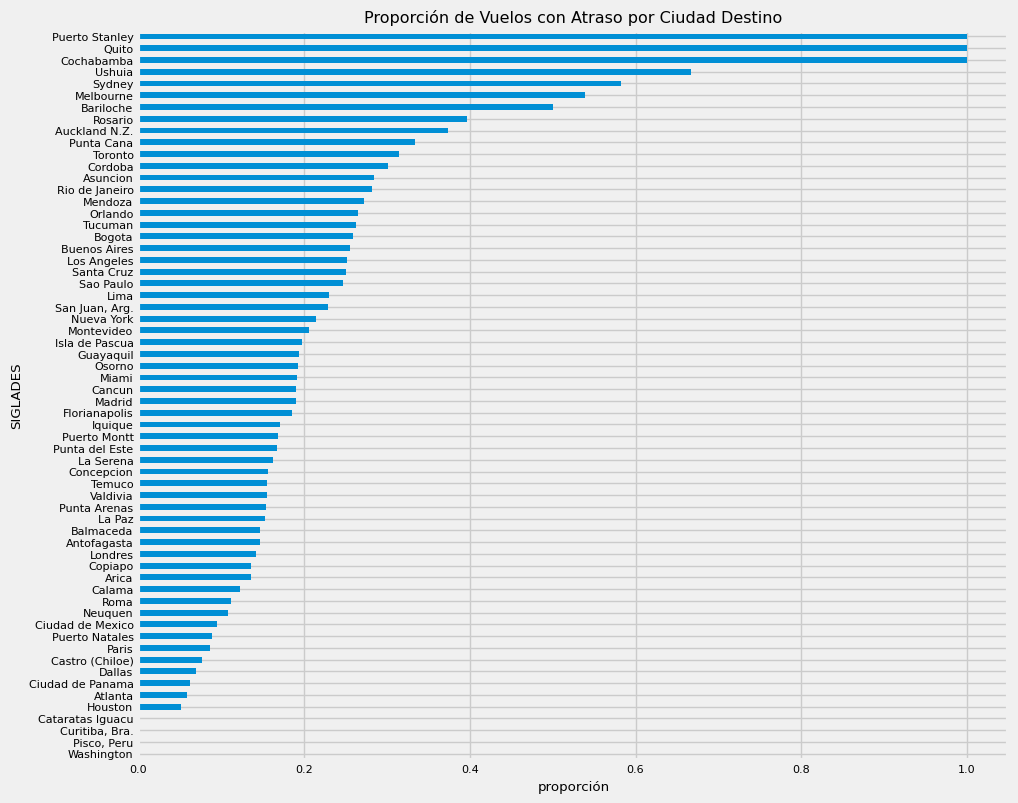

In [213]:
storage['SIGLADES'][[('atraso_15',  'mean')]].sort_values(('atraso_15',  'mean')).plot.barh(figsize=(10,9), legend=False)
plt.title('Proporción de Vuelos con Atraso por Ciudad Destino')
plt.xlabel('proporción')
plt.savefig('results/img/02_DELAY_ANALYSIS_CIUDAD-DESTINO.png')
plt.show()

In [16]:
storage['SIGLADES'].sort_values(('atraso_15',  'mean'), ascending=False).head(10)

atraso_15                    
                   count      mean       std
SIGLADES                                    
Quito                  2  1.000000  0.000000
Puerto Stanley         1  1.000000       NaN
Cochabamba             1  1.000000       NaN
Ushuia                 6  0.666667  0.516398
Sydney               194  0.582474  0.494427
Melbourne             39  0.538462  0.505035
Bariloche              2  0.500000  0.707107
Rosario              136  0.397059  0.491097
Auckland N.Z.        361  0.373961  0.484525
Punta Cana            54  0.333333  0.475831

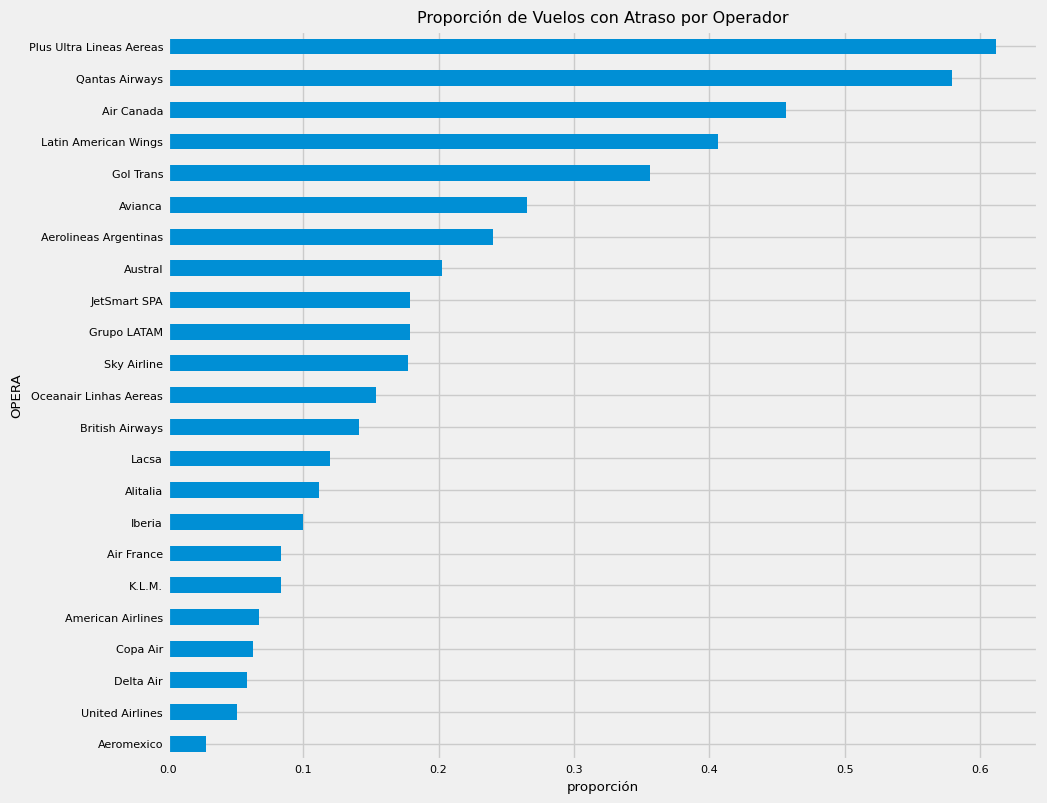

In [214]:
storage['OPERA'][[('atraso_15',  'mean')]].sort_values(('atraso_15',  'mean')).plot.barh(figsize=(10,9), legend=False)
plt.title('Proporción de Vuelos con Atraso por Operador')
plt.xlabel('proporción')
plt.savefig('results/img/02_DELAY_ANALYSIS_OPERADOR.png')
plt.show()

In [18]:
storage['OPERA'].sort_values(('atraso_15',  'mean'), ascending=False).head(10)

atraso_15                    
                             count      mean       std
OPERA                                                 
Plus Ultra Lineas Aereas        49  0.612245  0.492287
Qantas Airways                 195  0.579487  0.494912
Air Canada                     565  0.456637  0.498558
Latin American Wings          1674  0.406810  0.491386
Gol Trans                      806  0.356079  0.479136
Avianca                       1152  0.265625  0.441857
Aerolineas Argentinas         1949  0.240123  0.427268
Austral                         74  0.202703  0.404757
JetSmart SPA                  1095  0.178995  0.383524
Grupo LATAM                  40892  0.178666  0.383077

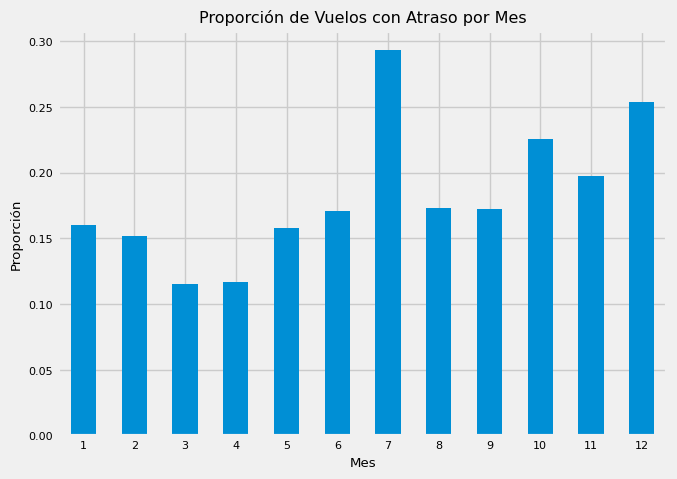

In [215]:
storage['MES'][[('atraso_15',  'mean')]].plot.bar(figsize=(7,5), legend=False, rot=0)
plt.title('Proporción de Vuelos con Atraso por Mes')
plt.ylabel('Proporción')
plt.xlabel('Mes')
plt.savefig('results/img/02_DELAY_ANALYSIS_MES.png')
plt.show()

In [20]:
storage['MES'].sort_values(('atraso_15',  'mean'), ascending=False).head(10)

atraso_15                    
        count      mean       std
MES                              
7        5992  0.293391  0.455354
12       6356  0.254091  0.435383
10       6032  0.225962  0.418249
11       6080  0.197204  0.397920
8        5744  0.173398  0.378624
9        5610  0.172371  0.377736
6        4981  0.171050  0.376590
1        6108  0.160118  0.366745
5        5240  0.157824  0.364611
2        5561  0.151591  0.358657

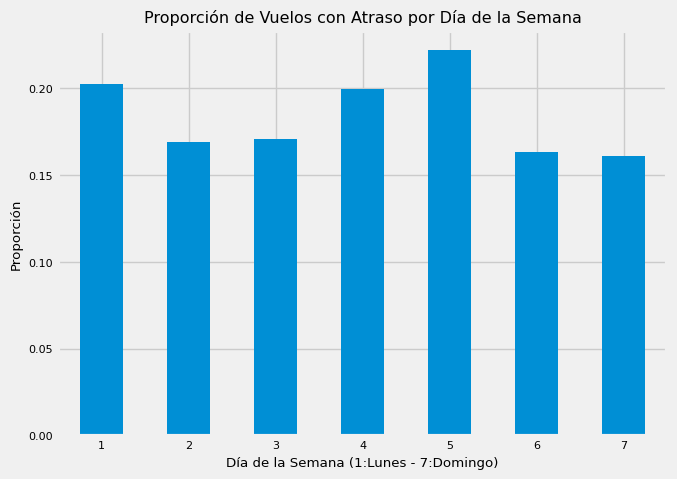

In [216]:
storage['DOW'][[('atraso_15',  'mean')]].plot.bar(figsize=(7,5), legend=False, rot=0)
plt.title('Proporción de Vuelos con Atraso por Día de la Semana')
plt.ylabel('Proporción')
plt.xlabel('Día de la Semana (1:Lunes - 7:Domingo)')
plt.savefig('results/img/02_DELAY_ANALYSIS_DIA-SEMANA.png')
plt.show()

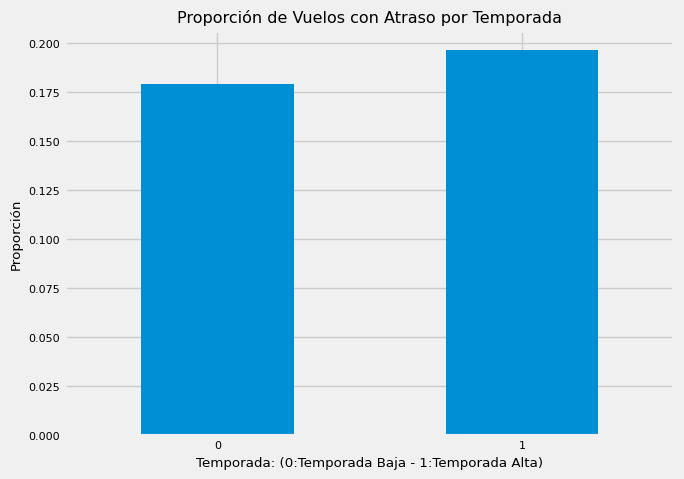

In [217]:
storage['temporada_alta'][[('atraso_15',  'mean')]].plot.bar(figsize=(7,5), legend=False, rot=0)
plt.title('Proporción de Vuelos con Atraso por Temporada')
plt.ylabel('Proporción')
plt.xlabel('Temporada: (0:Temporada Baja - 1:Temporada Alta)')
plt.savefig('results/img/02_DELAY_ANALYSIS_TEMPORADA-BINARIA.png')
plt.show()

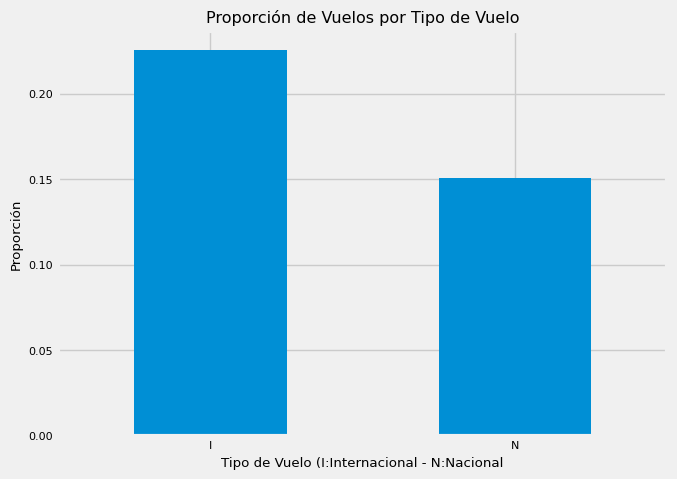

In [218]:
storage['TIPOVUELO'][[('atraso_15',  'mean')]].plot.bar(figsize=(7,5), legend=False, rot=0)
plt.title('Proporción de Vuelos por Tipo de Vuelo')
plt.ylabel('Proporción')
plt.xlabel('Tipo de Vuelo (I:Internacional - N:Nacional')
plt.savefig('results/img/02_DELAY_ANALYSIS_TIPOVUELO.png')
plt.show()

### Test ANOVA

In [25]:
anova_results = {}

for variable in ['SIGLADES', 'OPERA', 'MES', 'DOW', 'temporada_alta', 'TIPOVUELO']:

    f_stat, pvalue = f_oneway(
        *(df.loc[df[variable]==grupo, 'atraso_15']
          for grupo in df[variable].unique())
    )
    
    anova_results[variable] = {'f_stat':f_stat, 'pvalue':pvalue}
    
pd.DataFrame(anova_results).T

,f_stat,pvalue
SIGLADES,31.925164,0.000000e+00
OPERA,84.423633,0.000000e+00
MES,109.581701,1.986974e-249
DOW,36.816625,7.945825e-45
temporada_alta,29.674208,5.128653e-08
TIPOVUELO,638.351093,3.382523e-140


### Delay por Nuevas Variables

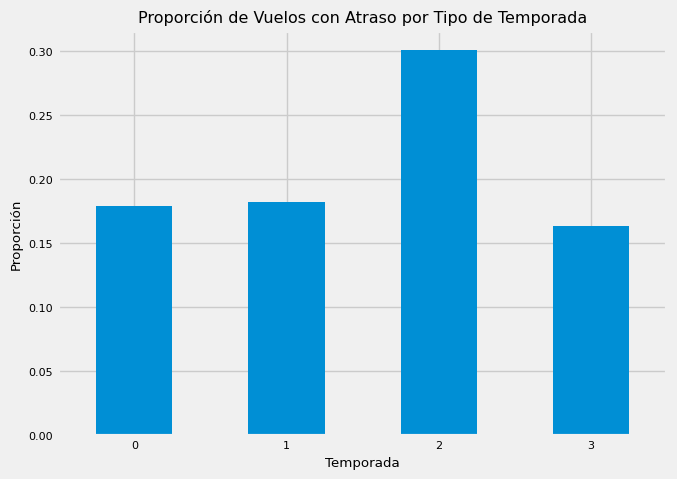

In [219]:
storage['temporada_alta_enriched'][[('atraso_15',  'mean')]].plot.bar(figsize=(7,5), legend=False, rot=0)
plt.title('Proporción de Vuelos con Atraso por Tipo de Temporada')
plt.ylabel('Proporción')
plt.xlabel('Temporada')
plt.savefig('results/img/02_DELAY_ANALYSIS_TEMPORADA-ENRICHED.png')
plt.show()

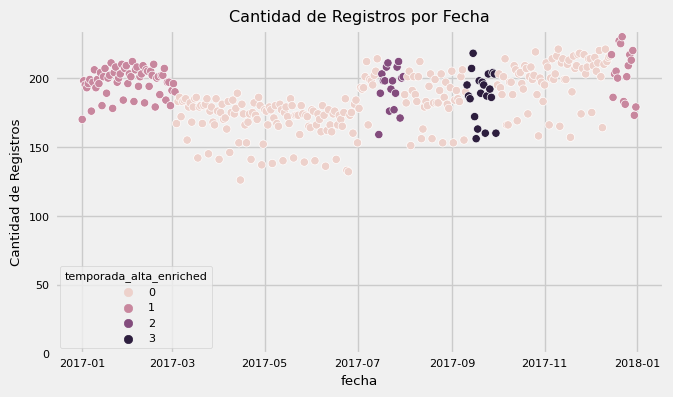

In [220]:
flights_number = df.groupby(['fecha', 'temporada_alta_enriched']).count()['Fecha-I'].reset_index()
flights_number.rename(columns={'Fecha-I':'vuelos_programados'}, inplace=True)

plt.figure(figsize=(7,4))
sns.scatterplot(data=flights_number, x='fecha', y='vuelos_programados', hue='temporada_alta_enriched')
plt.title('Cantidad de Registros por Fecha')
plt.ylabel('Cantidad de Registros')
plt.ylim(0)
plt.savefig('results/img/02_DELAY_ANALYSIS_REGISTROS-FECHA.png')
plt.show()

In [54]:
combinacion_temporadas = [x for x in combinations(df['temporada_alta_enriched'].unique(), 2)]

for x in combinacion_temporadas:
    
    temporada_x = x[0]
    temporada_y = x[1]
    
    atrasos_temporada_x = df.query(f'temporada_alta_enriched == {temporada_x}')['atraso_15']
    atrasos_temporada_y = df.query(f'temporada_alta_enriched == {temporada_y}')['atraso_15']
    
    t_stat, t_pvalue = ttest_ind(atrasos_temporada_x, atrasos_temporada_y)
    
    print(f'Temporada {temporada_x} - Temporada {temporada_y} -> (stat: {t_stat:f}, pvalue: {t_pvalue:f})')

Temporada 1 - Temporada 0 -> (stat: 0.872003, pvalue: 0.383210)
Temporada 1 - Temporada 2 -> (stat: -15.479630, pvalue: 0.000000)
Temporada 1 - Temporada 3 -> (stat: 2.675921, pvalue: 0.007459)
Temporada 0 - Temporada 2 -> (stat: -17.325967, pvalue: 0.000000)
Temporada 0 - Temporada 3 -> (stat: 2.389320, pvalue: 0.016883)
Temporada 2 - Temporada 3 -> (stat: 13.887240, pvalue: 0.000000)


### Weight Of Evidence (WOE) and Information Value (IV)

In [87]:
df_cat = df[['SIGLADES', 'OPERA', 'MES', 'DOW', 'temporada_alta', 'temporada_alta_enriched', 'TIPOVUELO', 'atraso_15']]
df_cat.head()

,SIGLADES,OPERA,MES,DOW,temporada_alta,temporada_alta_enriched,TIPOVUELO,atraso_15
0,Miami,American Airlines,1,7,1,1,I,0
1,Miami,American Airlines,1,1,1,1,I,0
2,Miami,American Airlines,1,2,1,1,I,0
3,Miami,American Airlines,1,3,1,1,I,0
4,Miami,American Airlines,1,4,1,1,I,0


In [140]:
def woe(data, variable, target):
    
    df_temp = df.groupby([variable])[[target]].mean()
    WOE = np.log(df_temp[target] / (1-df_temp[target]+0.0000001))

    return WOE.to_dict()

SIGLADES


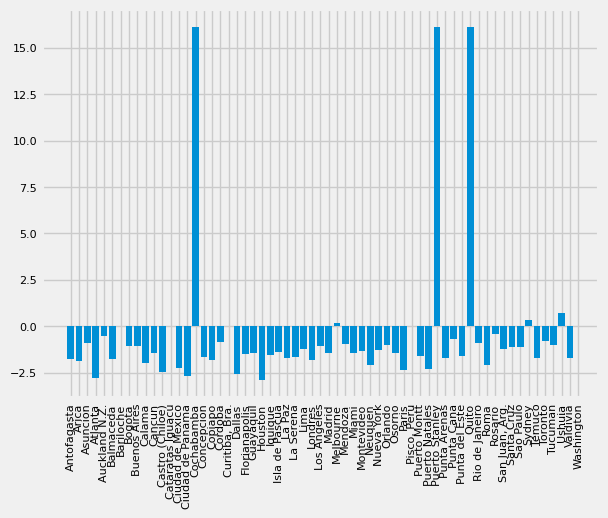

OPERA


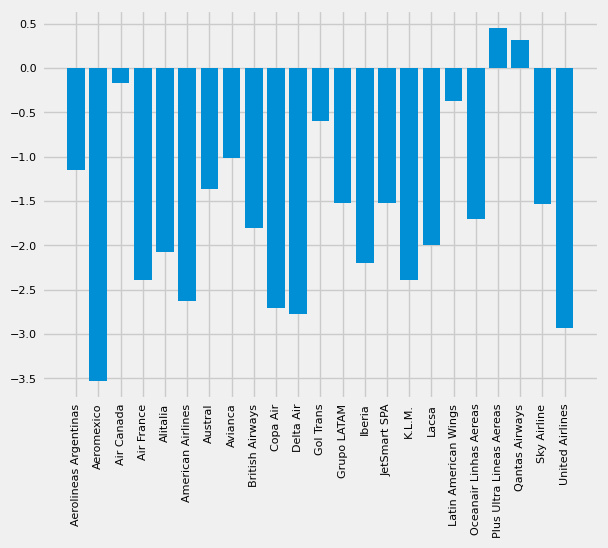

MES


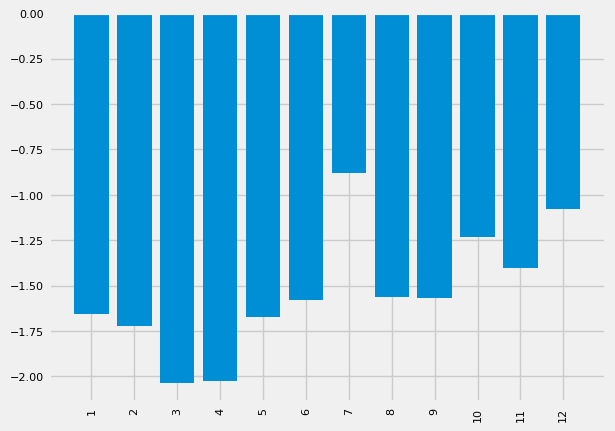

DOW


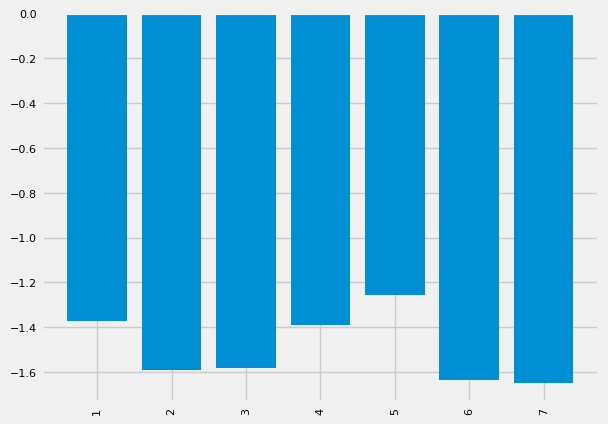

temporada_alta


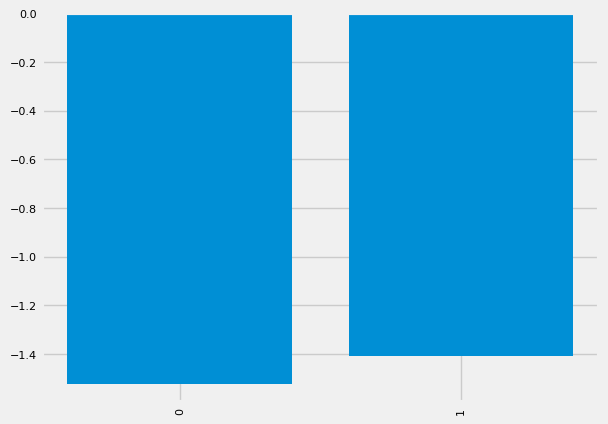

temporada_alta_enriched


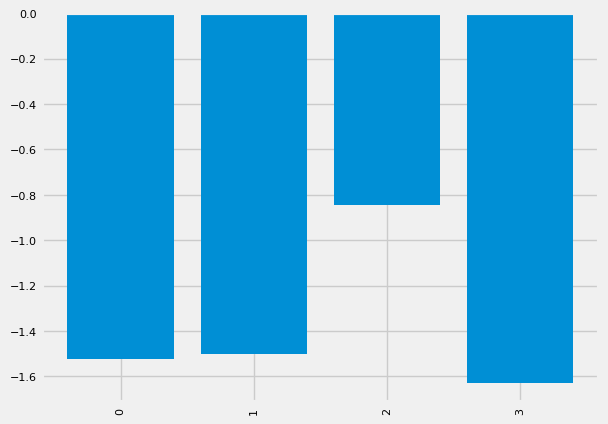

,SIGLADES,OPERA,MES,DOW,temporada_alta,temporada_alta_enriched,TIPOVUELO,atraso_15,WOE_SIGLADES,WOE_OPERA,WOE_MES,WOE_DOW,WOE_temporada_alta,WOE_temporada_alta_enriched
0,Miami,American Airlines,1,7,1,1,I,0,-1.443882,-2.62779,-1.657351,-1.650169,-1.409076,-1.500776
1,Miami,American Airlines,1,1,1,1,I,0,-1.443882,-2.62779,-1.657351,-1.372900,-1.409076,-1.500776
2,Miami,American Airlines,1,2,1,1,I,0,-1.443882,-2.62779,-1.657351,-1.591905,-1.409076,-1.500776
3,Miami,American Airlines,1,3,1,1,I,0,-1.443882,-2.62779,-1.657351,-1.579618,-1.409076,-1.500776
4,Miami,American Airlines,1,4,1,1,I,0,-1.443882,-2.62779,-1.657351,-1.389468,-1.409076,-1.500776


In [141]:

df_cat = df[['SIGLADES', 'OPERA', 'MES', 'DOW', 'temporada_alta', 'temporada_alta_enriched', 'TIPOVUELO', 'atraso_15']]

for variable_categorica in df_cat.columns:
    
    print(variable_categorica)
    
    if variable_categorica == 'atraso_15':
        continue
    
    woe_temp = woe(data=df_cat, variable=variable_categorica, target='atraso_15')
    
    plt.bar([str(x) for x in woe_temp.keys()], woe_temp.values())
    plt.xticks(rotation=90)
    plt.show()
    
    df_cat[f'WOE_{variable_categorica}'] = df_cat[variable_categorica].map(woe_temp)
    
    if variable_categorica == 'temporada_alta_enriched':
        break
    
df_cat.head()

<BarContainer object of 2 artists>

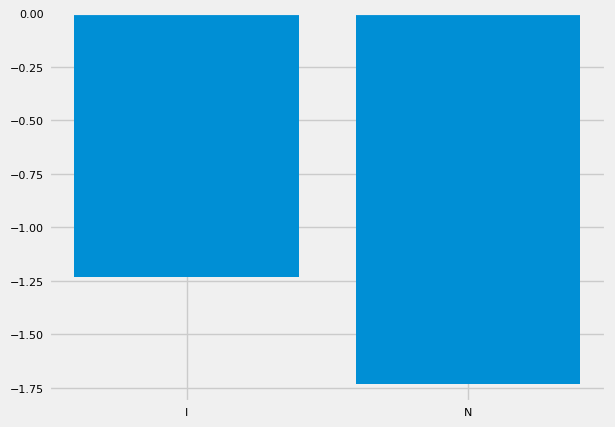

In [121]:
plt.bar(woe_temp.keys(), woe_temp.values())

### Chi-Square Test (Feature Selection)

In [146]:
from sklearn.preprocessing import OneHotEncoder

# Definición de Variable Dependiente
y = df.atraso_15

# Definición de Variables Independientes
X_columns = ['MES', 'DIANOM', 'TIPOVUELO', 'SIGLADES', 'temporada_alta_enriched', 'periodo_dia']
X = df[X_columns]




In [166]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=20230214)


encoder = OneHotEncoder(drop='first', sparse_output=False, min_frequency=20, handle_unknown='infrequent_if_exist')
encoder.fit(X_train)
X_train_encoded = encoder.transform(X_train)

X_train_encoded = encoder.transform(X_train)
X_test_encoded = encoder.transform(X_test)

In [167]:
df_x_train = pd.DataFrame(data=X_train_encoded, columns=encoder.get_feature_names_out())

In [168]:
chi2_features = SelectKBest(chi2, k=20)
X_kbest_features = chi2_features.fit_transform(df_x_train, y_train)

In [194]:
chi2_features = SelectKBest(chi2, k=20)
X_kbest_features = chi2_features.fit_transform(df_x_train, y_train)

chi2_results = pd.DataFrame({'variable':chi2_features.feature_names_in_,
                             'score':chi2_features.scores_,
                             'pvalue':chi2_features.pvalues_})

chi2_results.set_index('variable', inplace=True)

In [185]:
def get_sign_stars(pvalue):
    
    if pvalue < 0.001:
        return '***'
    elif pvalue < 0.01:
        return '**'
    elif pvalue < 0.05:
        return '*'
    else:
        return ''

In [195]:
chi2_results['significancia'] = chi2_results['pvalue'].apply(get_sign_stars)

In [211]:
?chi2_features.transform

Signature: chi2_features.transform(X)
Docstring:
Reduce X to the selected features.

Parameters
----------
X : array of shape [n_samples, n_features]
    The input samples.

Returns
-------
X_r : array of shape [n_samples, n_selected_features]
    The input samples with only the selected features.
File:      ~/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/feature_selection/_base.py
Type:      method

In [200]:
chi2_results.query('significancia == ""')

,score,pvalue,significancia
variable,,,
MES_8,2.188240,0.139068,
MES_11,2.864611,0.090548,
SIGLADES_Cancun,0.061564,0.804041,
SIGLADES_Florianapolis,0.307716,0.579085,
SIGLADES_Guayaquil,0.535897,0.464138,
SIGLADES_Iquique,1.291331,0.255803,
SIGLADES_Isla de Pascua,0.019875,0.887886,
SIGLADES_La Paz,0.836527,0.360392,
SIGLADES_Londres,3.590407,0.058114,


In [201]:
chi2_results.query('significancia != ""')

,score,pvalue,significancia
variable,,,
MES_2,30.704488,3.004692e-08,***
MES_3,119.236133,9.297580e-28,***
MES_4,89.268748,3.446612e-21,***
MES_5,19.281332,1.128039e-05,***
MES_6,3.965453,4.644303e-02,*
MES_7,325.192007,1.071514e-72,***
MES_9,4.047187,4.424501e-02,*
MES_10,43.168259,5.022896e-11,***
MES_12,131.547752,1.878997e-30,***


<AxesSubplot: ylabel='variable'>

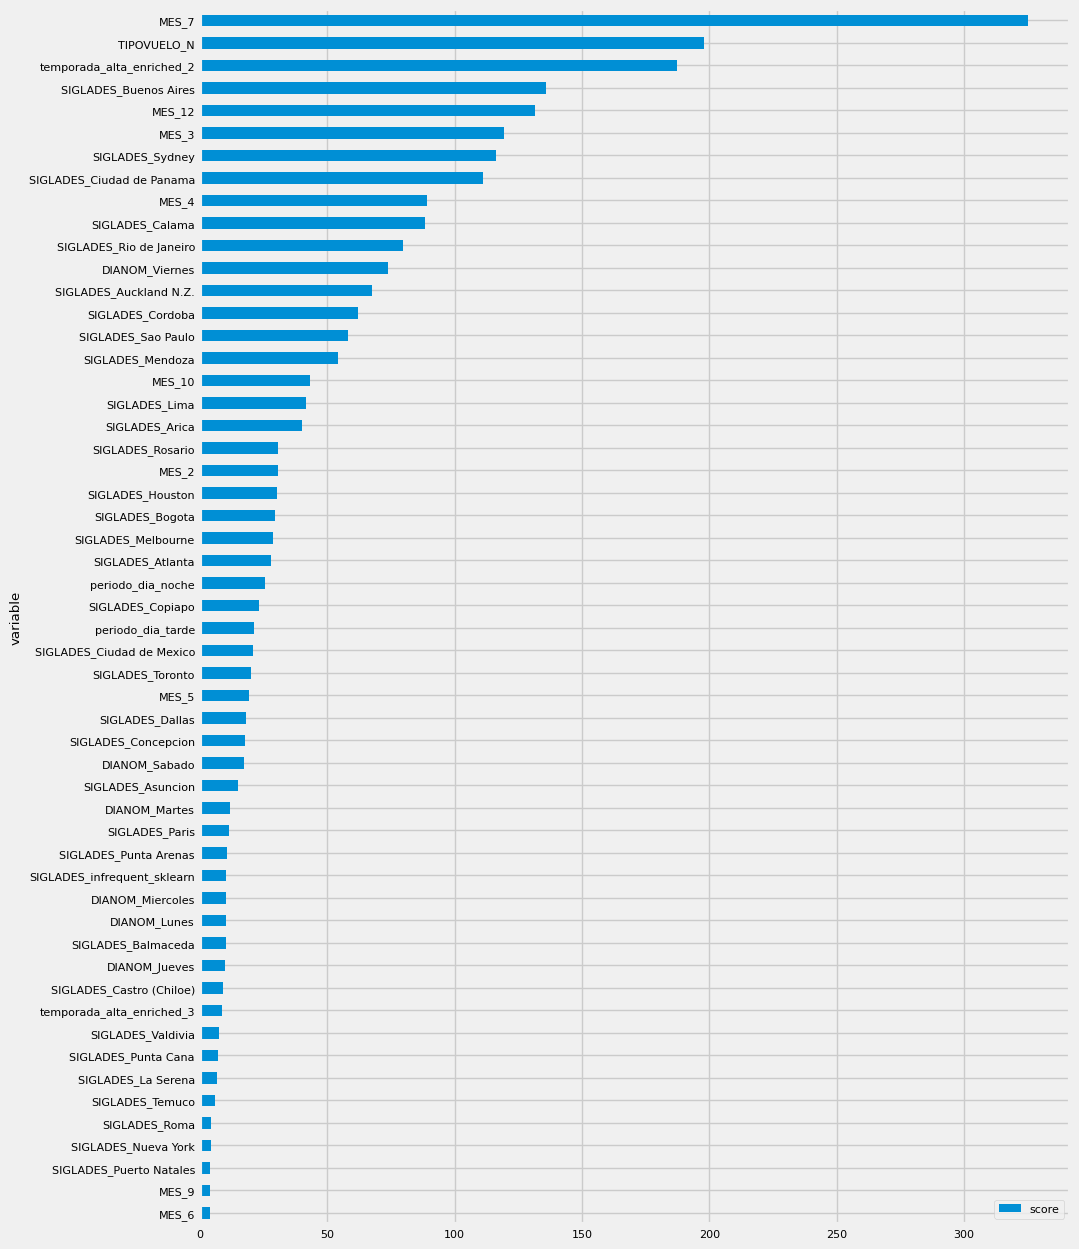

In [202]:
chi2_results.query('significancia != ""')[['score']].sort_values('score').plot.barh(figsize=(10,15))

In [207]:
list(chi2_results.query('pvalue < 0.05').index)

['MES_2',
 'MES_3',
 'MES_4',
 'MES_5',
 'MES_6',
 'MES_7',
 'MES_9',
 'MES_10',
 'MES_12',
 'DIANOM_Jueves',
 'DIANOM_Lunes',
 'DIANOM_Martes',
 'DIANOM_Miercoles',
 'DIANOM_Sabado',
 'DIANOM_Viernes',
 'TIPOVUELO_N',
 'SIGLADES_Arica',
 'SIGLADES_Asuncion',
 'SIGLADES_Atlanta',
 'SIGLADES_Auckland N.Z.',
 'SIGLADES_Balmaceda',
 'SIGLADES_Bogota',
 'SIGLADES_Buenos Aires',
 'SIGLADES_Calama',
 'SIGLADES_Castro (Chiloe)',
 'SIGLADES_Ciudad de Mexico',
 'SIGLADES_Ciudad de Panama',
 'SIGLADES_Concepcion',
 'SIGLADES_Copiapo',
 'SIGLADES_Cordoba',
 'SIGLADES_Dallas',
 'SIGLADES_Houston',
 'SIGLADES_La Serena',
 'SIGLADES_Lima',
 'SIGLADES_Melbourne',
 'SIGLADES_Mendoza',
 'SIGLADES_Nueva York',
 'SIGLADES_Paris',
 'SIGLADES_Puerto Natales',
 'SIGLADES_Punta Arenas',
 'SIGLADES_Punta Cana',
 'SIGLADES_Rio de Janeiro',
 'SIGLADES_Roma',
 'SIGLADES_Rosario',
 'SIGLADES_Sao Paulo',
 'SIGLADES_Sydney',
 'SIGLADES_Temuco',
 'SIGLADES_Toronto',
 'SIGLADES_Valdivia',
 'SIGLADES_infrequent_sklear